In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim

from models import U_Net_big
from RectifiedFlow import RectifiedFlow_Unet, train_translation

from util import load_MNIST, show_trajectories

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 512
train_dataset_6, test_dataset_6, train_dataloader_6, test_dataloader_6, classes_6 = load_MNIST(batch_size, classes=[6])
train_dataset_9, test_dataset_9, train_dataloader_9, test_dataloader_9, classes_9 = load_MNIST(batch_size, classes=[9])
input_shape = (batch_size, 2, 32, 32)

In [4]:
v_model_1 = U_Net_big(input_shape=input_shape, output_channels=1, device=device)
rectified_flow_1 = RectifiedFlow_Unet(v_model_1, device)

In [5]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-3)
scheduler_1 = None # optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=80, verbose=True)

In [6]:
def get_samples(shape, device):
    for batch in train_dataloader_9:
        samples,_ = batch
        samples = samples.to(device)
        break
    return samples

In [7]:
rectified_flow_1 = train_translation(rectified_flow_1, False, optimizer_1, scheduler_1, train_dataloader_6, get_samples, device, epochs=500, noise_factor=0.01)

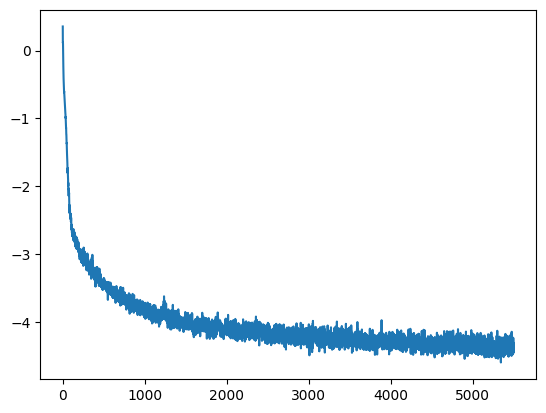

In [8]:
plt.plot(np.log(rectified_flow_1.loss_curve))
plt.show()

In [34]:
torch.save(rectified_flow_1, "./models/MNIST/MNIST_6to9_Unet_big.pth")

In [4]:
rectified_flow_1 = torch.load("./models/MNIST/MNIST_6to9_Unet_big.pth")

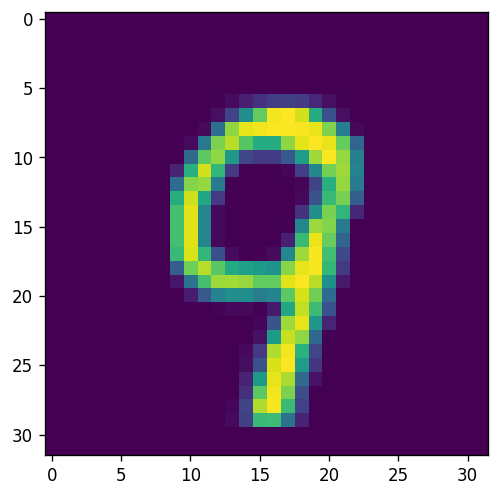

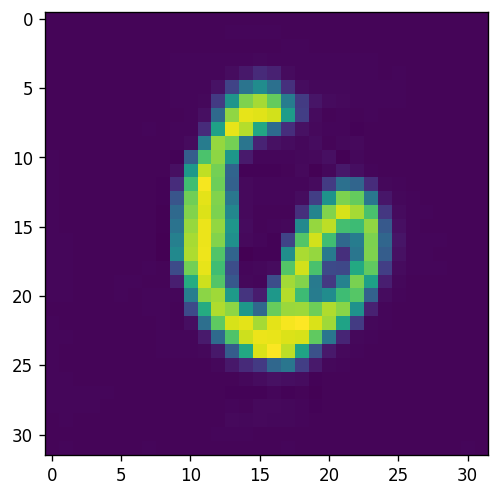

In [32]:
rectified_flow_1.v_model.eval()
img_init = get_samples(None, device)[:20]

plt.imshow(img_init[0, 0].detach().cpu().numpy())
plt.show()

img = rectified_flow_1.sample_ode(img_init, 100)

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

5
0


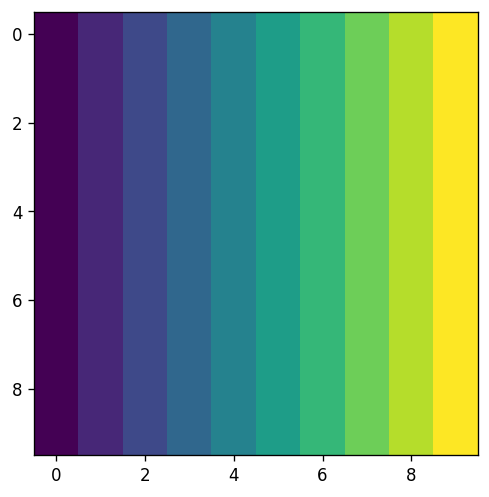

In [26]:
plt.imshow(np.array([np.arange(10) for i in range(10)]))
print(np.array([np.arange(10) for i in range(10)])[0,5])
print(np.array([np.arange(10) for i in range(10)])[5,0])

In [12]:
def show_trajectories2(rectified_flow, get_samples, num_samples, img_size, num_steps, x, y, device):
    rectified_flow.v_model.eval()
    plt.rcParams['figure.dpi'] = 120
    img_init = get_samples((num_samples, 1, img_size, img_size), device=device)[:num_samples]
    img = rectified_flow.sample_ode(img_init, num_steps)
    s = torch.zeros(num_samples, len(img), 1, 32, 32)
    for i in range(len(img)):
        s[:, i] = img[i]
    for i in range(num_samples):
        plt.plot(s[i, :, 0, x, y].cpu().numpy())
    plt.ylim(-1.8, 1.8)
    plt.show()

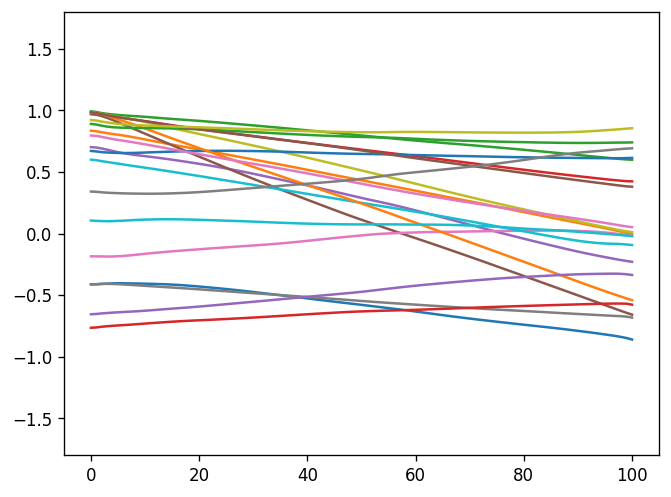

In [38]:
show_trajectories2(rectified_flow_1, get_samples, 20, 32, 100, 18,18, device)

[]

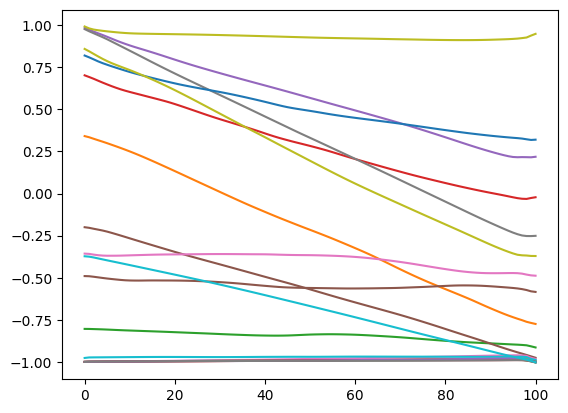

In [44]:
s = torch.zeros(20,len(img),1,32,32)
for i in range(len(img)):
    s[:,i] = img[i]
for i in range(20):
    plt.plot(s[i,:,0,15,15].cpu().numpy())
plt.plot()

In [16]:
def get_reverse_samples(shape, device):
    for batch in train_dataloader_6:
        samples,_ = batch
        samples = samples.to(device)
        break
    return samples

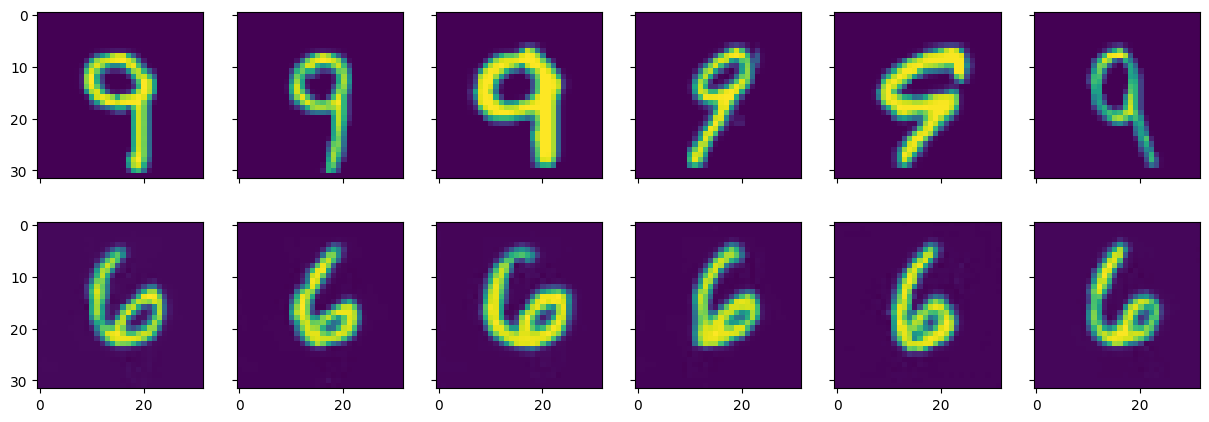

In [11]:
rows = 2
columns = 6
size = (15, 5)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)


for column in range(columns):
    img_init = get_samples(None, device)[:1]

    img = rectified_flow_1.sample_ode(img_init, 100)[-1][0,0].detach().cpu().numpy()
    ax[0, column].imshow(img_init[0,0].detach().cpu().numpy())

    ax[1, column].imshow(img)

plt.show()

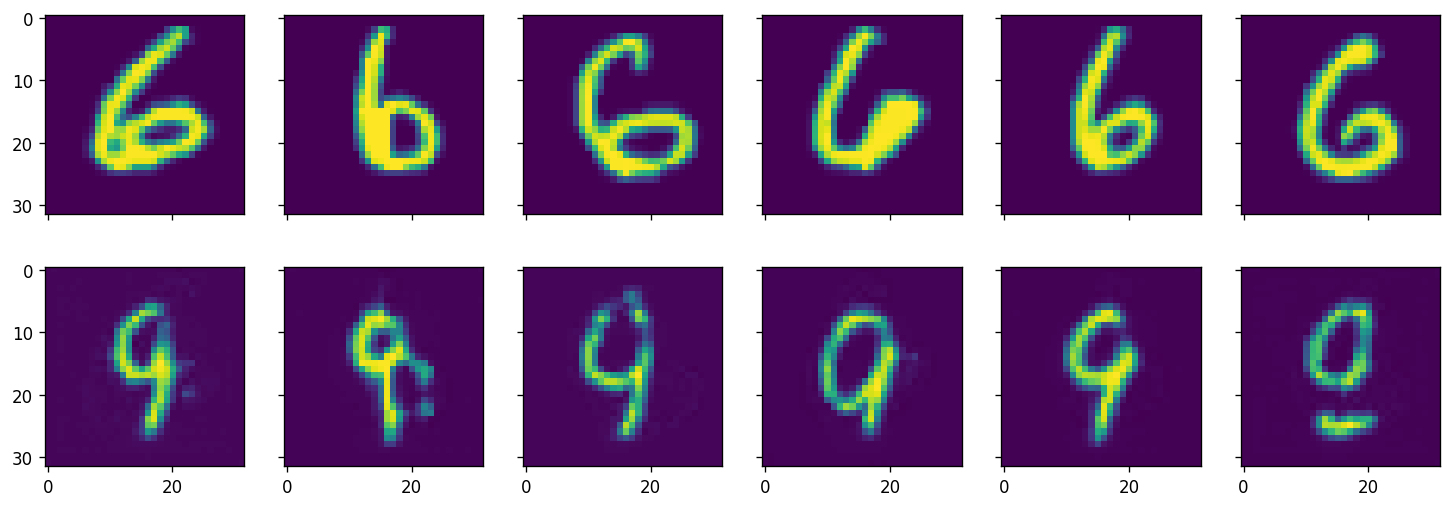

In [17]:
rows = 2
columns = 6
size = (15, 5)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)


for column in range(columns):
    img_init = get_reverse_samples(None, device)[:1]

    img = rectified_flow_1.reverse_sample_ode(img_init, 100)[-1][0,0].detach().cpu().numpy()
    ax[0, column].imshow(img_init[0,0].detach().cpu().numpy())

    ax[1, column].imshow(img)

plt.show()

In [14]:
def show_samples_translation(rectified_flow, get_samples, reverse, columns, channels, img_size, num_steps, device, conditional=False):
    plt.rcParams['figure.dpi'] = 120
    rectified_flow.v_model.eval()
    img_init = get_samples(
        (columns, channels, img_size, img_size), device=device)[:columns]
    if reverse:
        img = rectified_flow.reverse_sample_ode(img_init, num_steps)[-1]
    else:
        img = rectified_flow.sample_ode(img_init, num_steps)[-1]

    size = (4*columns, 4*2)
    fig, ax = plt.subplots(2, columns, figsize=(size),
                           sharex=True, sharey=True)

    
    for column in range(columns):
        i = column
        min = torch.min(img[i])
        img[i] = img[i] - min
        max = torch.max(img[i])
        img[i] = img[i] / max
        ax[1, column].imshow(
            img[i].permute(1,2,0).detach().cpu().numpy())

        ax[0, column].imshow(
            img_init[i].permute(1,2,0).detach().cpu().numpy())

    plt.xticks([])
    plt.yticks([])
    plt.show()

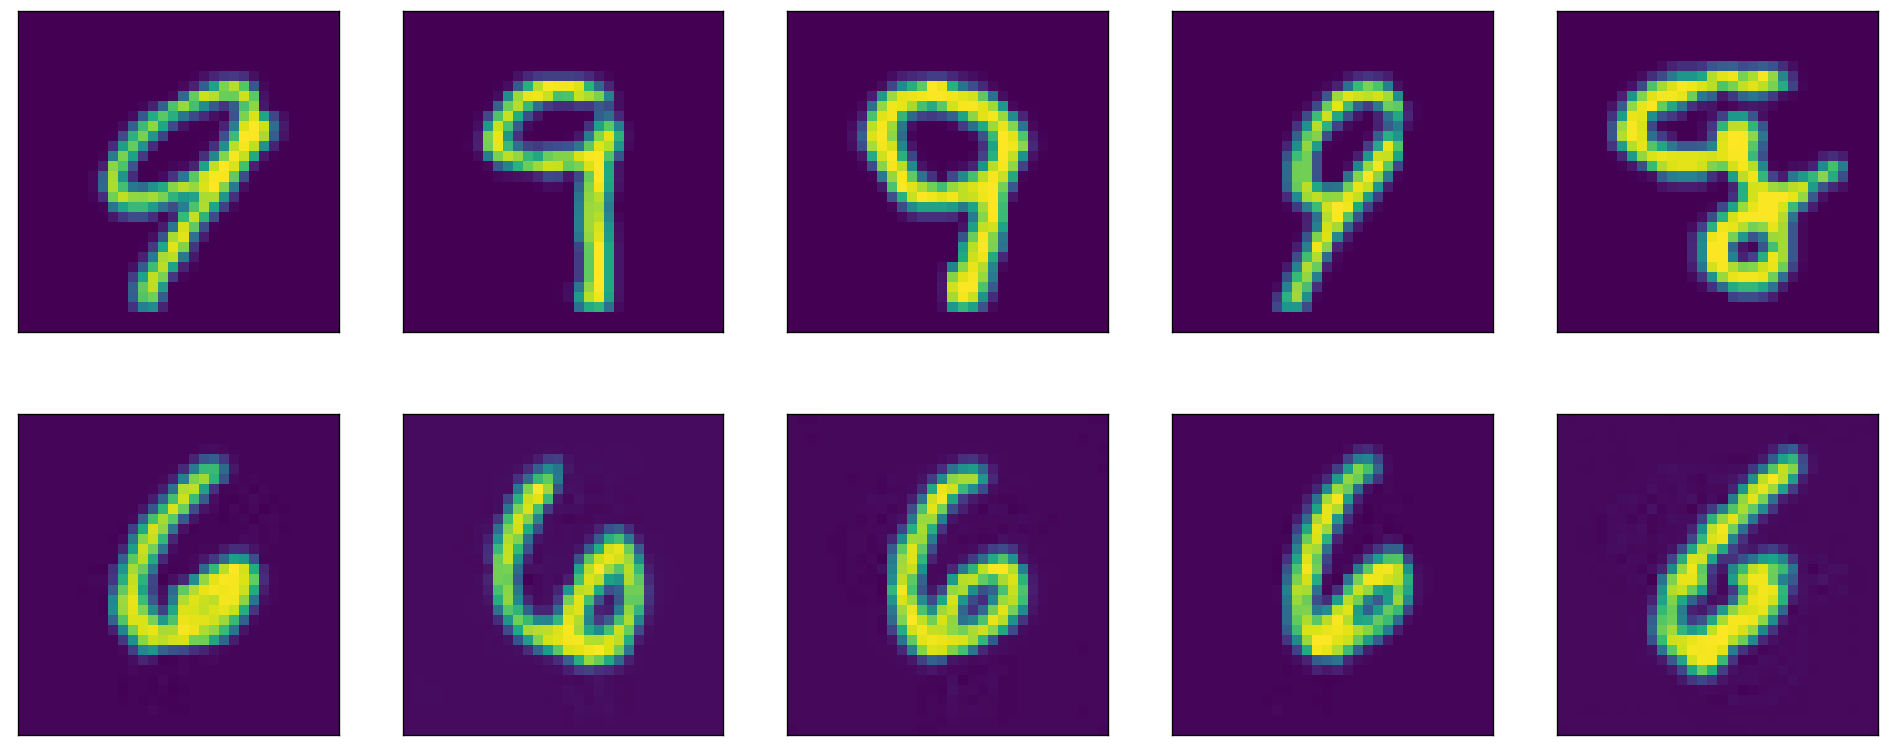

In [38]:
show_samples_translation(rectified_flow_1, get_samples, False, columns, 1, 32, 100, device)

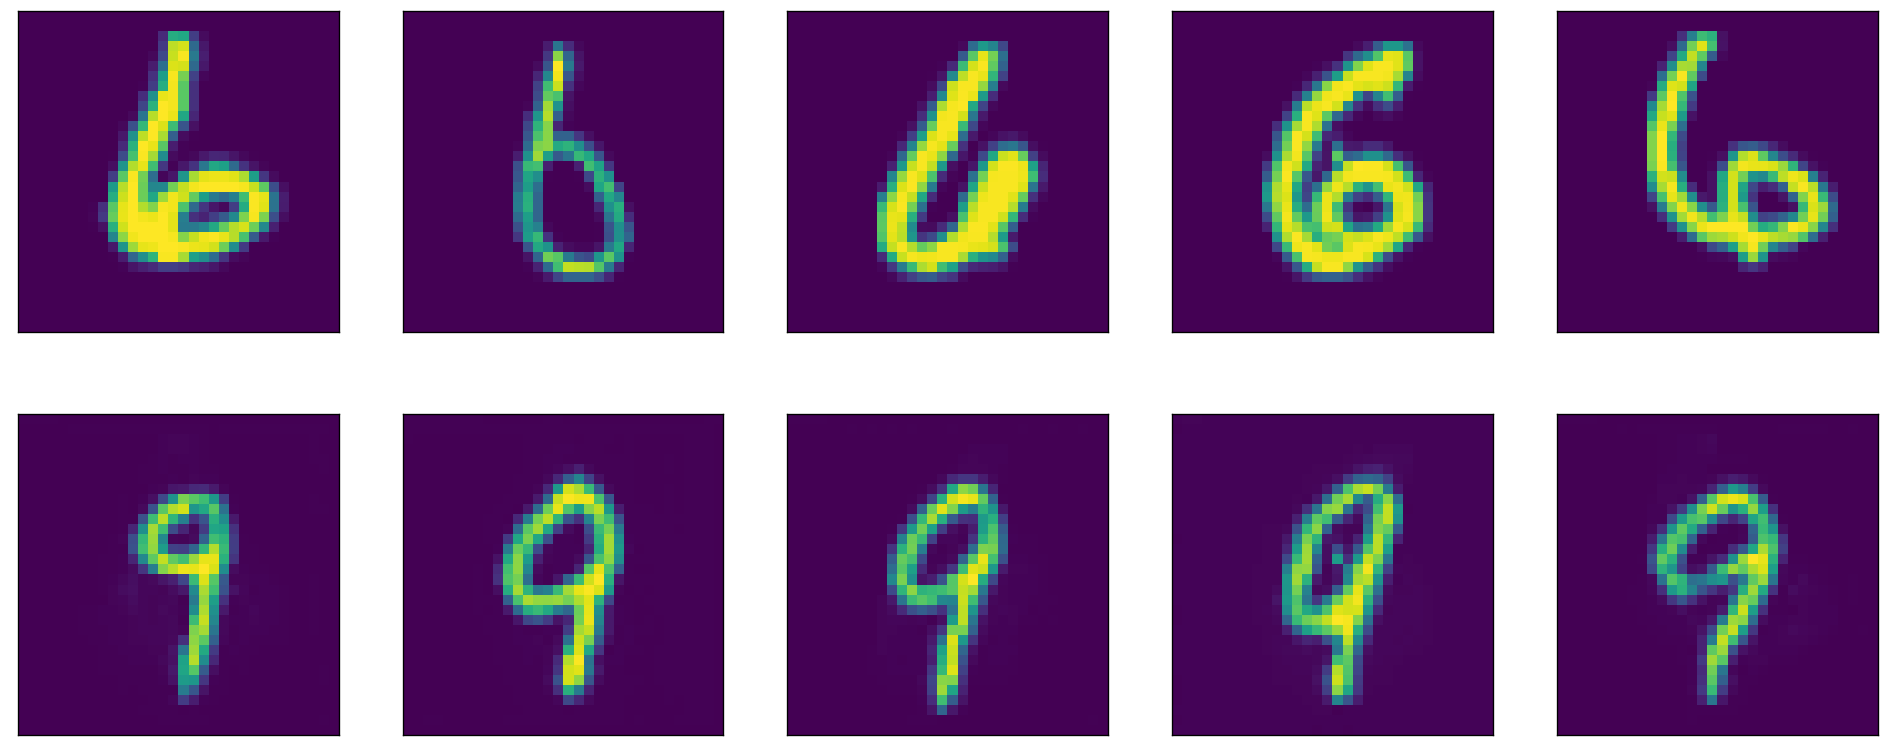

In [98]:
show_samples_translation(rectified_flow_1, get_reverse_samples, True, columns, 1, 32, 100, device)

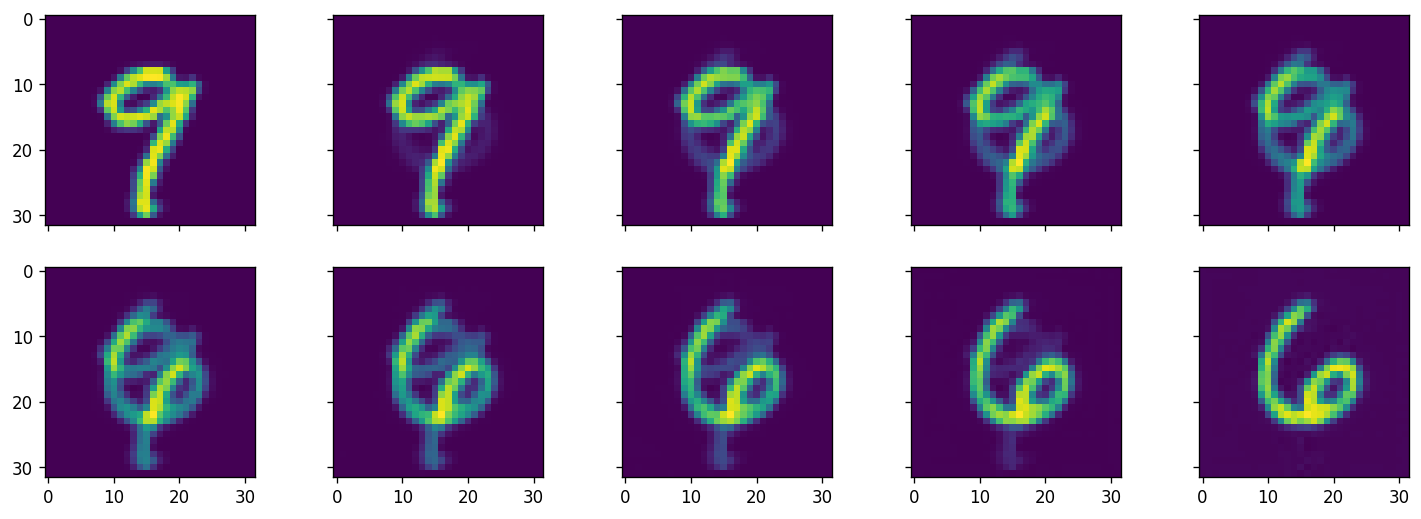

In [18]:
rows = 2
columns = 5
size = (15, 5)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

img_init = get_samples(None, device)[:1]

img = rectified_flow_1.sample_ode(img_init, 99)

for row in range(rows):
    for column in range(columns):
        i = row * columns + column
        ax[row, column].imshow(img[i*11][0,0].detach().cpu().numpy())

plt.show()

In [20]:
def show_trajectory_translation(rectified_flow, get_samples, rows, columns, channels, img_size, num_steps, device, conditional=False):
    plt.rcParams['figure.dpi'] = 120
    rectified_flow.v_model.eval()
    img_init = get_samples(
        (rows*columns, channels, img_size, img_size), device=device)[:1]
    img = rectified_flow.sample_ode(img_init, num_steps)

    size = (4*columns, 4*rows)
    fig, ax = plt.subplots(rows, columns, figsize=(size),
                           sharex=True, sharey=True)

    f = int(num_steps / (rows * columns -1))

    for row in range(rows):
        for column in range(columns):
            i = row * columns + column
            min = torch.min(img[i*f])
            img[i*f] = img[i*f] - min
            max = torch.max(img[i*f])
            img[i*f] = img[i*f] / max
            ax[row, column].imshow(
                img[i*f][0].permute(1,2,0).detach().cpu().numpy())
    
    plt.xticks([])
    plt.yticks([])
    plt.show()

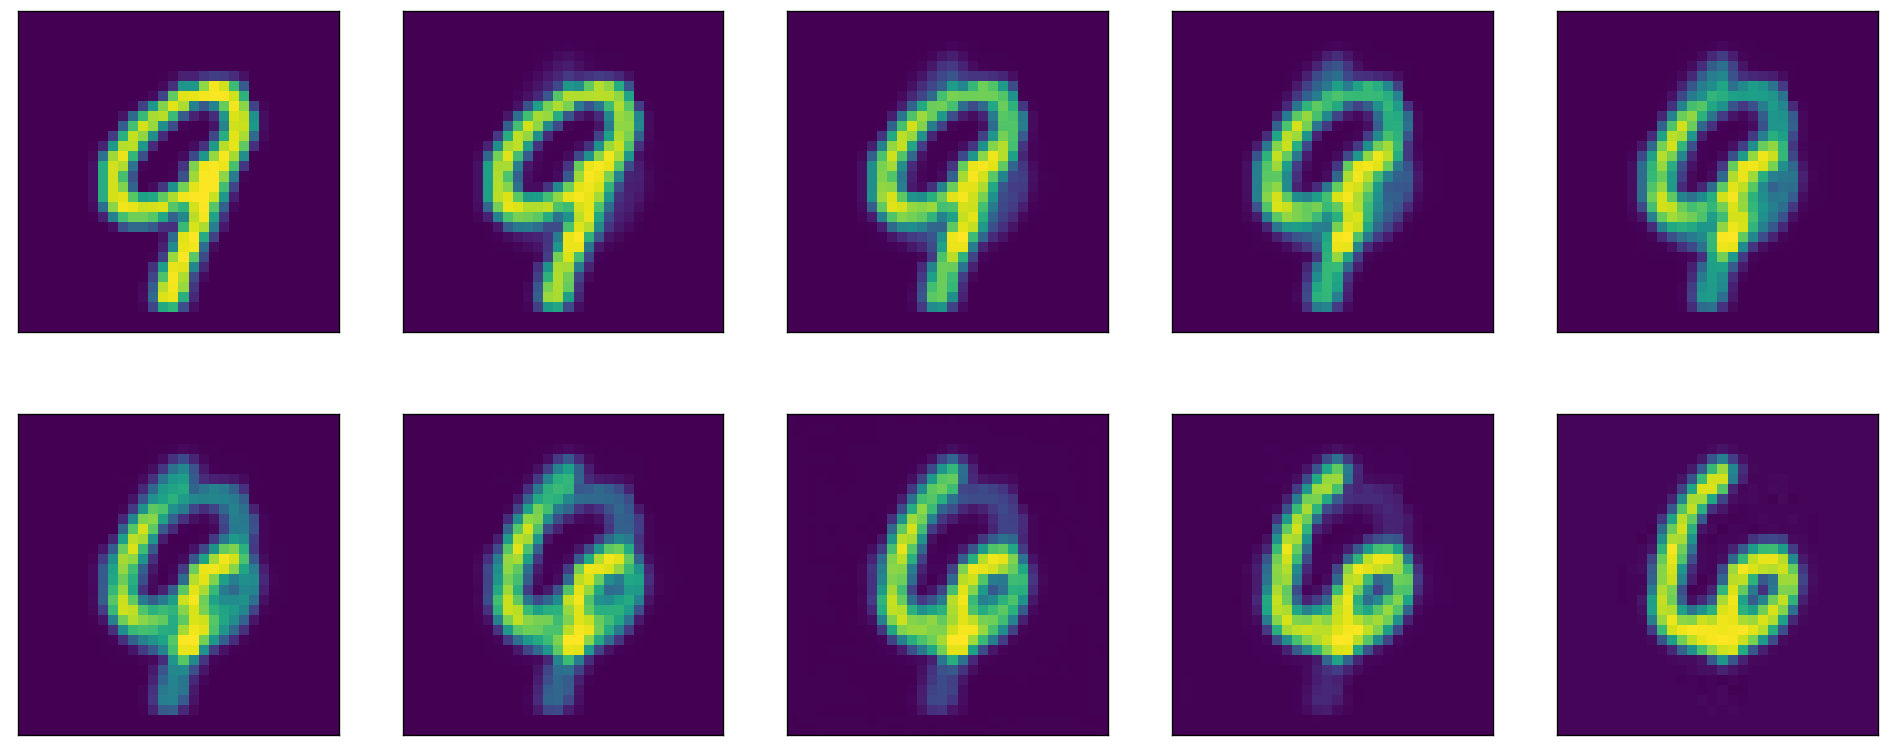

In [27]:
show_trajectory_translation(rectified_flow_1, get_samples, 2, 5, 0, 0, 99, device)